<a href="https://colab.research.google.com/github/hoihui/pkgs/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/hoihui/pkgs/blob/master/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# !pip3 install -U torch torchvision
import torch
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.__version__, cuda

('1.1.0', True)

# MNIST, MLP

https://github.com/udacity/deep-learning-v2-pytorch/blob/master/gan-mnist/MNIST_GAN_Solution.ipynb

In [0]:
import torch

imgsize = 28
batch_size = 64  # how many samples per batch to load
imgsize = 28
epochs = 50
patience = 2  #early stopping
lr = 0.002

## Load Data

In [4]:
from torchvision import datasets, transforms

train_data = datasets.MNIST(root='~/.pytorch/MNIST_data/', train=True, download=True, transform=transforms.ToTensor())
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
print(len(train_data))

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 20057934.31it/s]                            


Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-images-idx3-ubyte.gz


32768it [00:00, 331720.94it/s]
0it [00:00, ?it/s]

Extracting /root/.pytorch/MNIST_data/MNIST/raw/train-labels-idx1-ubyte.gz


1654784it [00:00, 4831133.42it/s]                           
8192it [00:00, 133010.76it/s]


Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-images-idx3-ubyte.gz
Extracting /root/.pytorch/MNIST_data/MNIST/raw/t10k-labels-idx1-ubyte.gz
Processing...
Done!
60000


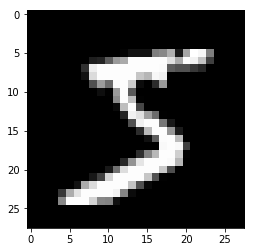

In [5]:
#visualize
images, labels = next(iter(train_loader))
plt.imshow(np.squeeze(images[0]), cmap='gray')

## Model

### Discriminator

linear classifier, with 3 hidden layers, using [Leaky Relu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation, where for $x<0$ the slope is slightly positive

outputs single number indicating *real*/*fake*

In [6]:
import torch.nn as nn
import torch.nn.functional as F

class Discriminator(nn.Module):

    def __init__(self, input_size, hidden_dim=32, output_size=1):
        super(Discriminator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim*4)
        self.fc2 = nn.Linear(hidden_dim*4, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim)        
        self.fc4 = nn.Linear(hidden_dim, output_size)
        
        self.dropout = nn.Dropout(0.3)        
        
    def forward(self, x):
        x = x.view(-1, 28*28)
        
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        return self.fc4(x)

D = Discriminator(input_size=784, hidden_dim=32, output_size=1)
print(D)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=1, bias=True)
  (dropout): Dropout(p=0.3)
)


In [7]:
images, labels = next(iter(train_loader))
print(images.shape)
print(D(images).shape)

torch.Size([64, 1, 28, 28])
torch.Size([64, 1])


### Generator

* inputs 784 random numbers, outputs 784 pixels
* Use `torch.tanh` instead of `torch.sigmoid` for output (why?)

In [8]:
class Generator(nn.Module):

    def __init__(self, input_size, hidden_dim=32, output_size=784):
        super(Generator, self).__init__()
        
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim*2)
        self.fc3 = nn.Linear(hidden_dim*2, hidden_dim*4)
        self.fc4 = nn.Linear(hidden_dim*4, output_size)
        
        self.dropout = nn.Dropout(0.3)

    def forward(self, x):
        x = F.leaky_relu(self.fc1(x), 0.2) # (input, negative_slope=0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc2(x), 0.2)
        x = self.dropout(x)
        x = F.leaky_relu(self.fc3(x), 0.2)
        x = self.dropout(x)
        
        return torch.tanh(self.fc4(x))

G = Generator(input_size=784, hidden_dim=32, output_size=784)
print(G)

Generator(
  (fc1): Linear(in_features=784, out_features=32, bias=True)
  (fc2): Linear(in_features=32, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=128, bias=True)
  (fc4): Linear(in_features=128, out_features=784, bias=True)
  (dropout): Dropout(p=0.3)
)


### Losses

* Use BCEWithLogitsLoss since D outputs just a number
* To help D generalize better, the true labels are **reduced from 1.0 to 0.9**
* Use different optimizer objects for Discriminator and Generator

In [0]:
criterion = nn.BCEWithLogitsLoss()
criterion_smooth = lambda pred, true: nn.BCEWithLogitsLoss()(pred,true*0.9)
d_optimizer = torch.optim.Adam(D.parameters(), lr)
g_optimizer = torch.optim.Adam(G.parameters(), lr)

## Train

In [0]:
print_every = 100
epochs = 100

In [0]:
# Get some fixed data for sampling. These are images that are held
# constant throughout training, and allow us to inspect the model's performance
sample_size=8
fixed_z = np.random.uniform(-1, 1, size=(sample_size, imgsize*imgsize))
fixed_z = torch.from_numpy(fixed_z).float()
def view_samples(epoch, samples, nrows=2, ncols=4):
    fig, axes = plt.subplots(figsize=(1.5*ncols,1.5*nrows), nrows=nrows, ncols=ncols, sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        img = img.detach()
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)
        im = ax.imshow(img.reshape((28,28)), cmap='Greys_r')
    plt.show()

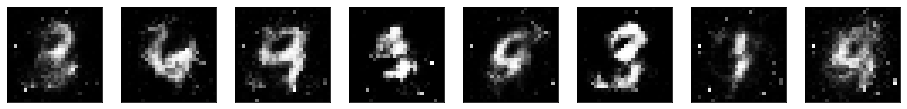

In [13]:
samples = []   # saves samples so visualize how the image quality improves over epochs

D.train()
G.train()
for epoch in range(epochs):
    for batch_i, (real_images, _) in enumerate(train_loader):                
        batch_size = real_images.size(0)        
        real_images = real_images*2 - 1  # rescale to [-1, 1) as G generates to this range
        
        # ============TRAIN THE DISCRIMINATOR=========        
        z = np.random.uniform(-1, 1, size=(batch_size, imgsize*imgsize))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z).view_as(real_images)
        
        allimages = torch.cat((real_images, fake_images), 0)  #concat on 0th axis
        alllabels = torch.cat((torch.ones(batch_size),torch.zeros(batch_size)), 0)
        
        d_optimizer.zero_grad()
        pred = D(allimages).squeeze()
        d_loss = criterion_smooth(pred,alllabels)
        d_loss.backward()
        d_optimizer.step()        
        
        # ===========TRAIN THE GENERATOR=============
        z = np.random.uniform(-1, 1, size=(batch_size, imgsize*imgsize))  #generates fake img
        z = torch.from_numpy(z).float()
        fake_images = G(z)
        
        g_optimizer.zero_grad()
        D_fake = D(fake_images)
        g_loss = criterion(D_fake.squeeze(), torch.ones(batch_size)) #min loss -> make D think the images are real        
        g_loss.backward()
        g_optimizer.step()

        if batch_i % print_every == 0:
            print(f'Epoch {epoch+1:5d} | d_loss: {d_loss.item():6.4f} | g_loss: {g_loss.item():6.4f}')
        
    from IPython.display import clear_output
    clear_output()
    G.eval()  # eval mode for generating samples
    samples += G(fixed_z),
    G.train() # back to train mode
    view_samples(-1,samples,1,8)

## Evaluate

### Visualize training progress

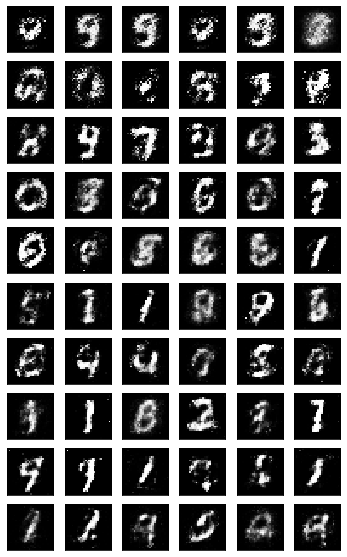

In [15]:
nrows = 10 # split epochs into 10, so 100/10 = every 10 epochs
ncols = 6
fig, axes = plt.subplots(figsize=(ncols,nrows), nrows=nrows, ncols=ncols, sharex=True, sharey=True)

for sample, ax_row in zip(samples[::int(len(samples)/nrows)], axes):
    for img, ax in zip(sample[::int(len(sample)/ncols)], ax_row):
        img = img.detach()
        ax.imshow(img.reshape((28,28)), cmap='Greys_r')
        ax.xaxis.set_visible(False)
        ax.yaxis.set_visible(False)

### Generate new

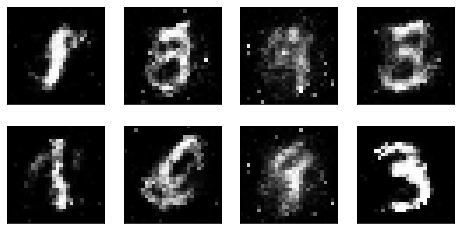

In [16]:
G.eval()

sample_size=8
rand_z = np.random.uniform(-1, 1, size=(sample_size, imgsize*imgsize))
rand_z = torch.from_numpy(rand_z).float()
rand_images = G(rand_z)

view_samples(0, [rand_images])